# GPU Info

In [1]:
!nvidia-smi

Fri Feb 21 11:24:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 960M        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P0             N/A /  200W |     299MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports

In [23]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader,random_split

import torchvision
import torchvision.transforms as T

from PIL import Image

from tqdm import tqdm
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

from os import listdir, system, getcwd
import re

In [3]:
torch.__version__, torchvision.__version__

('2.5.1+cu121', '0.20.1+cu121')

# Device and Inits

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
image_size = 256

batch_size = 128

# Functions and Classes

In [6]:
def num_parameters(model):
    return sum([p.numel() for p in model.parameters()])

In [7]:
class Averaging():
    def __init__(self):
        self.sum = 0.
        self.counter = 0

    def __call__(self, val: float) -> float:
        self.sum += val
        self.counter += 1

        return self.sum / self.counter

    def reset(self):
        self.sum = 0.
        self.counter = 0

In [8]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, acc_fn, avg_fn, ep, device):
    acc_fn.reset()
    avg_fn.reset()

    with tqdm(dataloader, desc=f"Epoch {ep}", unit=" batch") as trange:
        for x_batch, y_batch in trange:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate average loss and accuracy for each batch
            avg_loss = avg_fn(loss.item())
            
            acc_fn(yp, y_batch)
            acc = acc_fn().compute().item()

            trange.set_postfix(loss=loss.item(), accuracy=100*acc)

    return model, loss.item(), 100*acc

In [9]:
def validate_one_epoch(model, dataloader, loss_fn, acc_fn, avg_fn, device):
    acc_fn.reset()
    avg_fn.reset()

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward
        yp = model(x_batch)
        loss = loss_fn(yp, y_batch)

        # Calculate average loss and accuracy for each batch
        avg_loss = avg_fn(loss.item())
        
        acc_fn(yp, y_batch)
        acc = acc_fn().compute().item()

    return loss.item(), 100*acc

# Custom Dataset

In [10]:
class MRIDataset(Dataset):
    def __init__(self, transforms, dir_path=getcwd()+"/brain_mri_dataset/lgg-mri-segmentation/kaggle_3m"):
        self.transforms = transforms
        self.image_pattern = r".tif"
        self.mask_pattern = r"_mask"
        self.images_ls = []
        self.masks_ls = []

        self.to_tensor_transform = T.ToTensor()

        patients_path = listdir(dir_path)
        
        patients_path.remove("data.csv")
        patients_path.remove("README.md")
        patients_path.remove(".ipynb_checkpoints")

        for patient in patients_path:
            patient_images = listdir(f"{dir_path}/{patient}/")
            patient_images.sort(key=lambda x:x.replace(self.mask_pattern, ""))
            
            for img_path in patient_images:
                if re.search(self.image_pattern, img_path) is None:
                    continue
                
                if re.search(self.mask_pattern, img_path) is None:
                    self.images_ls.append(f"{dir_path}/{patient}/{img_path}")
                else:
                    self.masks_ls.append(f"{dir_path}/{patient}/{img_path}")
            

    def __getitem__(self, item_idx):
        pil_img = Image.open(self.images_ls[item_idx])
        transformed_img = self.transforms(pil_img)
        
        pil_mask = Image.open(self.masks_ls[item_idx])
        transformed_mask = self.to_tensor_transform(pil_mask)

        label = 1 if torch.max(transformed_mask) > 0 else 0
        
        return transformed_img, label
    
    def raw_item(self, item_idx):
        img = Image.open(self.images_ls[item_idx])
        mask = Image.open(self.masks_ls[item_idx])
        label = 1 if torch.max(self.to_tensor_transform(mask)) > 0 else 0
        
        return self.to_tensor_transform(img), self.to_tensor_transform(mask), label
    
    def __len__(self):
        return len(self.images_ls)

# Preprocessing

## Transforms

In [11]:
img_transforms = T.Compose([
    T.RandomVerticalFlip(),
    T.RandomRotation(60),
    T.AutoAugment(),
    T.ToTensor(),
    T.Normalize(mean=[0.2481, 0.1816, 0.2628], std=[0.3391, 0.2814, 0.3455])
])

## Read dataset

In [12]:
dataset = MRIDataset(img_transforms)

dataset.__len__()

3929

## Visualize Random 6 Samples with Their Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3333334].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4549019].


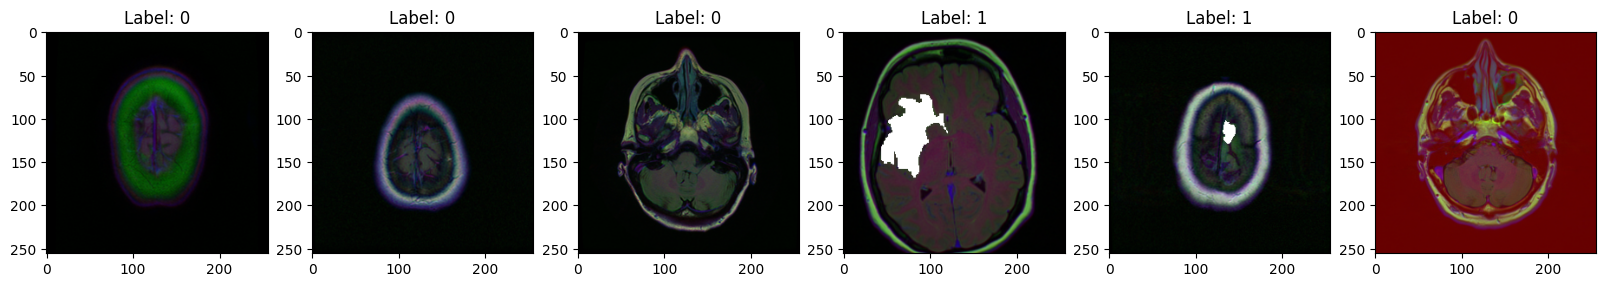

In [17]:
num_images = 6
fig, axs = plt.subplots(nrows=1, ncols=num_images)
fig.set_figwidth(20)

for idx, item_idx in enumerate(torch.randint(dataset.__len__(), (num_images,))):
    img, mask, label = dataset.raw_item(item_idx)
    img_with_mask = img + mask

    axs[idx].set_title(f"Label: {label}")
    axs[idx].imshow(img_with_mask.permute(1, 2, 0))

## Split Train, Valid, Test sets

In [14]:
train_set, valid_set, test_set = random_split(dataset, [0.7, 0.2, 0.1])

len(train_set.indices), len(valid_set.indices), len(test_set.indices)

(2751, 786, 392)

## Make Dataloader

In [15]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512)
test_loader = DataLoader(test_set, batch_size=512)

In [18]:
img, label = next(iter(train_loader))

img.shape, label.shape

(torch.Size([256, 3, 256, 256]), torch.Size([256]))

# U-Net Model

In [97]:
pic = torch.randn([3, 256, 256])

pic.shape

torch.Size([3, 256, 256])

In [98]:
pic_conv = nn.Conv2d(3, 16, 5, 1, 2)(pic)

pic_conv.shape

torch.Size([16, 256, 256])

In [99]:
pic_max_1 = nn.MaxPool2d(5, 2, 2)(pic_conv)

pic_max_1.shape

torch.Size([16, 128, 128])

In [114]:
pic_up_1 = nn.ConvTranspose2d(16, 32, 3, 2, 1)(pic_max_1)

pic_up_1.shape

torch.Size([32, 255, 255])

In [168]:
class UNetModel(nn.Module):
    def __init__(self, input_channel=3, num_cls=2):
        super().__init__()

        conv_channels = [input_channel] + [64, 128, 256, 512, 1024]
        conv_channels_len = len(conv_channels)
        self.conv_ls = nn.ModuleList()
        
        # Encoder
        for channel_num in range(1, conv_channels_len):
            self.conv_ls.append(self.normal_convolution(conv_channels[channel_num-1], conv_channels[channel_num]))
            self.conv_ls.append(self.normal_convolution(conv_channels[channel_num], conv_channels[channel_num]))
        
            # The Stride of the MaxPool must be equal 2 to exactly halve the height and width of the image
            nn.MaxPool2d(3, 2)

        # Decoder
        for channel_num in range(conv_channels_len-1, 1, -1):
            self.conv_ls.append(self.up_convolution(conv_channels[channel_num], conv_channels[channel_num-1]))
            self.conv_ls.append(self.normal_convolution(conv_channels[channel_num], conv_channels[channel_num-1]))
            self.conv_ls.append(self.normal_convolution(conv_channels[channel_num-1], conv_channels[channel_num-1]))

        # Classifier Layer (The last layer)
        self.conv_ls[-1] = nn.Linear(conv_channels[1], num_cls)
        
    def __repr__(self):
        print(self.conv_ls)
        
        return "U-Net()"
    
    def normal_convolution(self, in_channels, out_channels, kernel=3, stride=1, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def up_convolution(self, in_channels, out_channels, kernel=3, stride=2, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self):
        pass

In [169]:
model = UNetModel()
model

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

U-Net()

# Chack Paths

## Forward Path

## Backward Path

# Full Train

# Save the Trained Model

# Testing Phase